In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def alpha_matting(image, trimap):
    # Convert trimap to binary mask
    mask = np.zeros_like(trimap, dtype=np.uint8)
    mask[trimap == 0] = cv2.GC_BGD  # Background
    mask[trimap == 50] = cv2.GC_PR_BGD  # Probably Background
    mask[trimap == 255] = cv2.GC_FGD  # Foreground
    mask[trimap == 70] = cv2.GC_PR_FGD  # Probably Foreground

    
    # Initialize background and foreground models
    bgd_model = np.zeros((1, 65), dtype=np.float64)
    fgd_model = np.zeros((1, 65), dtype=np.float64)
    
    # Perform GrabCut algorithm
    cv2.grabCut(image, mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    foreground = image*mask2[:,:,np.newaxis]

    alpha = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')

    return foreground,alpha

def merge_object_background(object_image, background_image, alpha):
    # Resize background image to match object image
    background_image = cv2.resize(background_image, (object_image.shape[1], object_image.shape[0]))

    # Merge object and background using alpha matte
    merged_image = np.zeros_like(object_image)
    merged_image[:, :, 0] = object_image[:, :, 0] * (alpha / 255) + background_image[:, :, 0] * (1 - alpha / 255)
    merged_image[:, :, 1] = object_image[:, :, 1] * (alpha / 255) + background_image[:, :, 1] * (1 - alpha / 255)
    merged_image[:, :, 2] = object_image[:, :, 2] * (alpha / 255) + background_image[:, :, 2] * (1 - alpha / 255)

    return merged_image

In [35]:
# Load object and background images
object_image = cv2.imread('GT04_Real.png')
background_image = cv2.imread('background2.jpg')

# Load trimap or create one (128 for uncertain regions)
trimap = cv2.imread('GT04.png', cv2.IMREAD_GRAYSCALE)

# Perform alpha matting
foreground,alpha = alpha_matting(object_image, trimap)

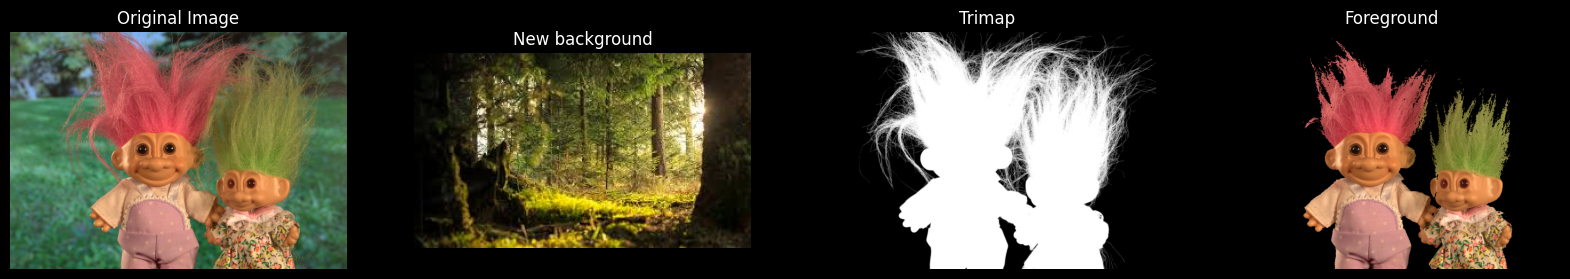

In [36]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 4, 1)
plt.imshow(cv2.cvtColor(object_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB))
plt.title('New background')
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(cv2.cvtColor(trimap, cv2.COLOR_BGR2RGB))
plt.title('Trimap')
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))
plt.title('Foreground')
plt.axis('off')

plt.show()

In [37]:
def post_process_alpha(alpha):
    # Apply morphological closing to fill small holes in the alpha matte
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    alpha_closed = cv2.morphologyEx(alpha, cv2.MORPH_CLOSE, kernel)

    # Apply Gaussian blur to smooth the alpha matte edges
    alpha_smooth = cv2.GaussianBlur(alpha_closed, (9, 9), 0)

    return alpha_smooth

In [38]:
# After obtaining alpha matte from alpha_matting function
alpha_smooth = post_process_alpha(alpha)

# Merge object onto background
merged_image = merge_object_background(object_image, background_image, alpha_smooth)

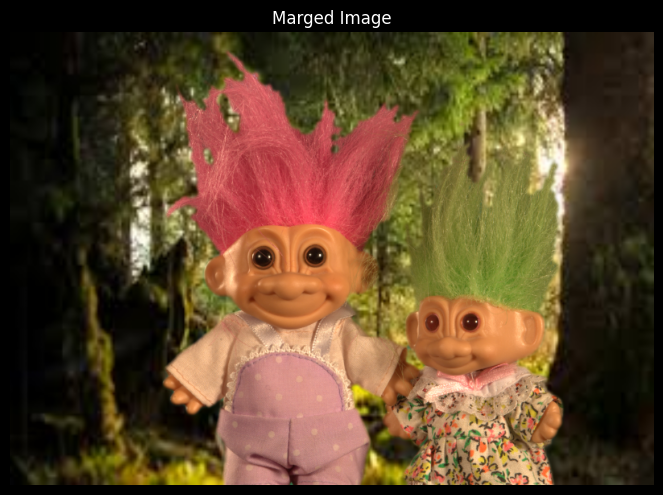

In [39]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 1)
plt.imshow(cv2.cvtColor(merged_image, cv2.COLOR_BGR2RGB))
plt.title('Marged Image')
plt.axis('off')
plt.show()

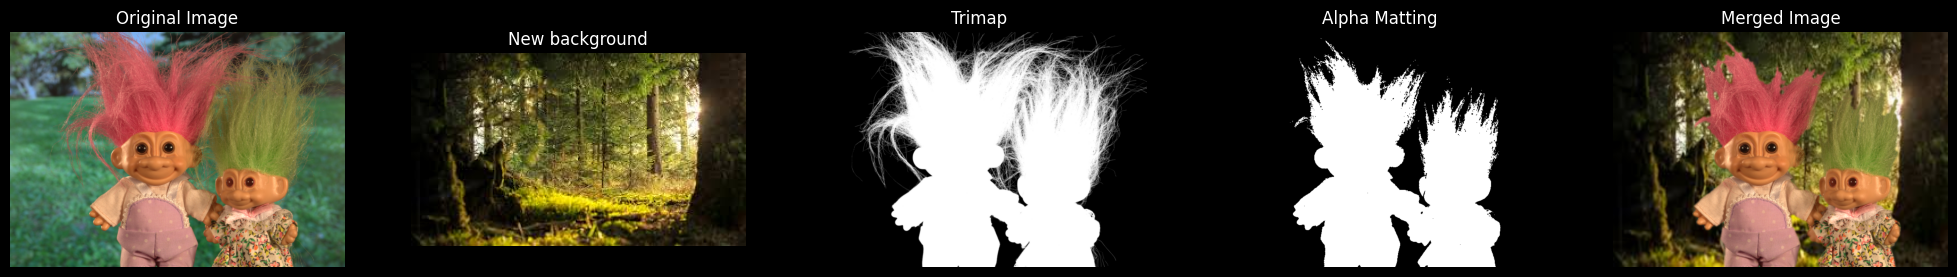

In [40]:
plt.figure(figsize=(25, 25))


plt.subplot(3, 5, 1)
plt.imshow(cv2.cvtColor(object_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(3, 5, 2)
plt.imshow(cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB))
plt.title('New background')
plt.axis('off')


plt.subplot(3, 5, 3)
plt.imshow(cv2.cvtColor(trimap, cv2.COLOR_BGR2RGB))
plt.title('Trimap')
plt.axis('off')

plt.subplot(3, 5, 4)
plt.imshow(cv2.cvtColor(alpha, cv2.COLOR_BGR2RGB))
plt.title('Alpha Matting')
plt.axis('off')

plt.subplot(3, 5, 5)
plt.imshow(cv2.cvtColor(merged_image, cv2.COLOR_BGR2RGB))
plt.title('Merged Image')
plt.axis('off')
plt.show()